1. Повторить график 28.6 из книги MacKay. Выборка: одна из стандартных датасетов sklearn. Модели: несколько моделей линейной регрессии:
    1. соответствующая оптимальному значению Evidence, с оптимальными значениями гиперпараметров
    2. с сниженной дисперсией sigma^2 относительно оптимальных значений
    3. со смещением среднего значения параметров относительно оптимальных значений (см. график)
Априорное распределение параметров: нормальное распределение со скалярным параметром дисперсии дисперсией (N(0, sigma^2 * I)).
* [datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)
* [книга](http://www.inference.org.uk/itprnn/book.pdf)
* [оптимизация гиперпараметров](http://strijov.com/papers/HyperOptimizationEng.pdf)

Рассматривается модель линейной регрессии

$$\mathbf{y} = \mathbf{Xw} + \epsilon, \epsilon \sim \mathcal{N}(\mathbf{0}, \sigma^2\mathbf{I}),$$ 
где $\mathbf{y} \in \mathbb{R}^n, \mathbf{X} \in\mathbb{R}^{n\times d}, \mathbf{w} \in\mathbb{R}^d$.

$$p(\mathbf{y}|\mathbf{X}, \mathbf{w}) = \prod^n_{i=1} \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\sigma^2 (y_i -\mathbf{w}^Tx_i)^2}=\frac{1}{(2\pi)^{n/2}\sigma^n} e^{-\frac{1}{2}\sigma^2 \|\mathbf{y}-\mathbf{Xw}\|^2}.$$

### Приорное распредение: 
$$\mathbf{w} \sim \mathcal{N}(\mu, \mathbf{A}^{-1}).$$

При этом, мы параметризуем мартицу $\mathbf{A}$ как диагональную матрицу.

### Совместное правдоподобие: 
$$p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \mu, \mathbf{A}, \sigma^2) = p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2)p(\mathbf{w}|\mu, \mathbf{A}).$$

### Обоснованность: 
$$p(\mathbf{y}|\mathbf{X}, \mu, \mathbf{A}) = \int p(\mathbf{y}, \mathbf{w}|\mathbf{X}, \mu, \mathbf{A}, \sigma^2)d\mathbf{w} = \int p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2)p(\mathbf{w}|\mu, \mathbf{A})dw.$$

$$\mathbf{y}|\mathbf{X}, \mu, \mathbf{A}, \sigma^2 \sim \mathcal{N}(\mathbf{y}|\mathbf{X}\mu, \sigma^2 \mathbf{I} + \mathbf{XA}^{-1}\mathbf{X}^T)$$

### Апостериорное распределение:
Рассмотрим $p(\mathbf{w}|\mu, \mathbf{A}) = \mathcal{N}(\mu, \mathbf{A}^{-1})$, тогда

$$ - \log p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \mu, \mathbf{A}) \propto \frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{Xw}\|^2 + \frac{1}{2} (\mathbf{w } - \mu)^T\mathbf{A}(\mathbf{w} - \mu) = \frac{1}{2\sigma^2} \mathbf{y}^T\mathbf{y} - \frac{1}{\sigma^2}\mathbf{y}^T\mathbf{Xw} + \frac{1}{2\sigma^2}\mathbf{w}^T\mathbf{X}^T\mathbf{Xw} + \frac{1}{2} \mathbf{w}^T\mathbf{Aw} - \mu^T\mathbf{Aw} + \frac{1}{2} \mu^T\mathbf{A}\mu \propto$$

$$\propto \frac{1}{2}\left(\mathbf{w}^T(\mathbf{A} + \frac{1}{\sigma^2} \mathbf{X}^T\mathbf{X})\mathbf{w} -
2 (\frac{1}{\sigma^2}\mathbf{y}^T\mathbf{X} + \mu^T\mathbf{A})\mathbf{w}\right) \propto \frac{1}{2}(\mathbf{w} - \mathbf{m})^T\Sigma^{-1}(\mathbf{w} - \mathbf{m}),$$

где $\mathbf{m} = \left(\sigma^2 \mathbf{A} + \mathbf{X}^T\mathbf{X}\right)^{-1} \left(\mathbf{X}^T\mathbf{y} + \sigma^2 \mathbf{A}\mu\right)$, $\Sigma  = \left(\mathbf{A} + \frac{1}{\sigma^2} \mathbf{X}^T\mathbf{X}\right)^{-1}$.

Таким образом, $p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \mu, \mathbf{A}) \propto  e^{-\frac{1}{2}(\mathbf{w}-\mathbf{m})^T\Sigma^{-1}(\mathbf{w}-\mathbf{m})}$.

## Подготовка данных

In [87]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [27]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
data = preprocessing.StandardScaler().fit_transform(data)
target = raw_df.values[1::2, 2]
target = preprocessing.StandardScaler().fit_transform(target[..., None]).flatten()

sigma_y = 0.1

## Опишем тут дополнительные функции, которыми будем пользоваться

In [26]:
def get_right_evidence(X, y, sigma_y):
    X = torch.Tensor(X)
    y = torch.Tensor(y)
    alpha = torch.nn.Parameter(torch.normal(0, 0.001, size=(X.size(1),)))
    optimizer = torch.optim.SGD([alpha], lr=1e-8)

    for epoch in range(100):
        optimizer.zero_grad()

        inner = sigma_y * torch.eye(X.size(0)) + X.mm(torch.diag(alpha)).mm(X.T)
        loss = torch.logdet(inner) + torch.inverse(inner).mv(y).dot(y)

        loss.backward()
        optimizer.step()
    
    return 1 / torch.clamp(alpha.detach(), min=0.).numpy()

In [57]:
def get_evidence_along_data_axis(X, mu, prior, sigma):
    m = X.dot(mu)
    s = sigma * np.eye(X.shape[0]) + X.dot(np.diag(1/prior)).dot(X.T)
    return m, s

In [72]:
def get_pasterior(X, y, mu, prior, sigma):
    s = sigma * np.diag(1/prior) + data.T.dot(data)
    m = np.linalg.inv(s).dot(X.T.dot(y) + sigma * np.diag(1/prior).dot(mu))
    s = s / sigma
    return m, s

## Итоговый график для обоснованности. (Ось у в книги MacKay)

In [163]:
prior = get_right_evidence(data, target, sigma_y)
prior

array([405.42004 , 296.4789  , 594.3677  , 435.49957 , 185.10492 ,
        29.672861, 120.84956 ,  26.02442 , 277.69916 , 388.46625 ,
       169.00096 , 388.42532 , 131.37415 ], dtype=float32)

In [164]:
y2plot = np.random.randint(0, data.shape[0], 1).item()
ev_y1 = get_evidence_along_data_axis(data, np.zeros(13), prior, sigma_y)
prior1 = prior / 10
ev_y2 = get_evidence_along_data_axis(data, np.ones(13), 
                                     prior1, sigma_y)
mu2 = np.random.normal(scale=0.5, size=prior.shape)
ev_y3 = get_evidence_along_data_axis(data, mu2, prior, sigma_y)

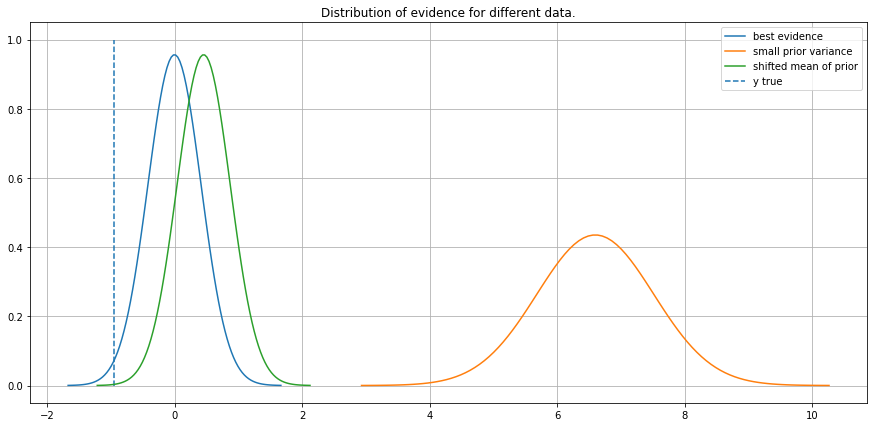

In [165]:
fig = plt.figure(figsize=(15, 7))
names = ['best evidence', 'small prior variance', 'shifted mean of prior']
for i, ev_y in enumerate([ev_y1, ev_y2, ev_y3]):
    mu = ev_y[0][y2plot]
    variance = ev_y[1][y2plot, y2plot]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=names[i])
plt.vlines(target[y2plot], 0, 1, linestyles='--', label = 'y true')
plt.title('Distribution of evidence for different data.')
plt.grid()
plt.legend()
plt.show()

Так как у нас более сложная задача, чем показано в книги, то результаты получаются сложно интерпретируемые. В книги берется простой одномерный вариант, у нас реальная задача. Поэтой причине изначальная модель линейной регресси может быть вообще некорректна. Для того, чтобы можно было изобразить распределения я беру какой-то случайный `y` и строю распределение для него.

Из графика видно, что 
* оптимальные параметры имеют наибольшую вероятность обоснованности для данного `y`. 
* уменьшение дисперсии приорного распределения ведет к увеличению дисперсии обоснованности. Что достаточно логично, потому что чем "шире" приорное распределение, тем больше возможности у можели идеально выучить только данный набор семплов. Видимо "широкое" приорное распредеелние увеличивает обобщающую способность.

In [166]:
w2plot = np.random.randint(0, data.shape[1], 1).item()
post1 = get_pasterior(data, target, np.zeros(13), prior, sigma_y)
post2 = get_pasterior(data, target, np.zeros(13), prior1, sigma_y)
post3 = get_pasterior(data, target, mu2, prior, sigma_y)

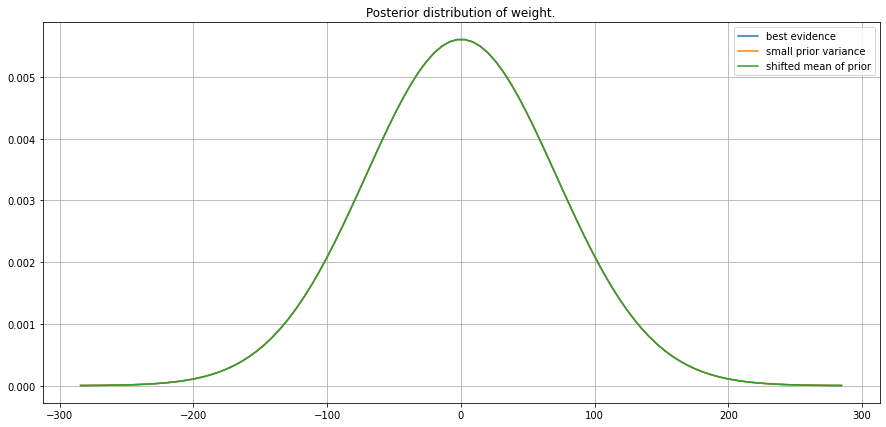

In [167]:
fig = plt.figure(figsize=(15, 7))
names = ['best evidence', 'small prior variance', 'shifted mean of prior']
for i, post in enumerate([post1, post2, post3]):
    mu = post[0][w2plot]
    variance = post[1][w2plot, w2plot]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=names[i])
plt.legend()
plt.title('Posterior distribution of weight.')
plt.grid()
plt.show()

Постериорное распределние меняется очень слабо при изменении параметров априорного распределения. 